Pyloric Rhythm Similarity Criteria:
1. All three neurons oscillate
2. In every cycle (AB/PD start to next AD/PD start), LP begins before PY starts and ends before PY ends, AB/PD finishes before LP starts

3. 15 other criteria from Table 1 in (Prinz et al., 2004)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
def sigmoid(x):
    return 1/(1+np.exp(-x))
def invsigmoid(x):
    return np.log(x/(1-x))
labels = ["LP","PY","PD"]

In [3]:
class CTRNN():

    def __init__(self,size,dt,duration,slidingwindow,bdry,weights,biases,timeconsts):
        self.Size = size                                         # number of neurons in the circuit
        self.States = np.ones(size)                              # state of the neurons
        self.Outputs = np.zeros(size)                            # neuron outputs
        self.bdry = bdry * np.ones(size)                         # offsets of the homeostatic target range from 0 and 1 (numpy array)
        self.rhos = np.zeros(size)                               # store the plastic facilitation parameter of each neuron
        self.dt = dt                                             # size of integration timestep, in seconds
        self.duration = duration                                 # duration in seconds
        self.time = np.arange(0.0,self.duration,dt)              # timeseries values in seconds
        self.ctrnn_record = np.zeros((size,len(self.time)))      # place to store data of the node outputs over time
        self.Stepnum = 0                                         # initialize the step count at 0
        self.slidingwindow = slidingwindow                       # how far back to go in timesteps to calculate avg_firingrate (& avg_speed)
        self.invadaptWTimeConsts = 40 * np.ones((size,size))     # default weight adaptive time constant = 40
        self.invadaptBTimeConsts = 20 * np.ones(size)            # default bias adaptive time constant = 20
        self.max_firingrate = np.zeros(self.Size)                # keep track of the maximum firing rate (for diagnostic)
        self.min_firingrate = np.ones(self.Size)                 # keep track of the minimum firing rate (for diagnostic)
        self.Weights = np.copy(weights)                          # weight matrix (numpy array)
        self.Biases = np.copy(biases)                            # bias values (numpy array)
        self.invTimeConstants = 1.0/np.copy(timeconsts)          # inverse taus (numpy array)
        self.bias_record = np.zeros((size,len(self.time)))       # since parameters of the system are changing under the HP, track biases
        self.weight_record = np.zeros((size,size,len(self.time)))# track weights
        self.Inputs = np.zeros((size))                           # external input default to zero
             
    def resetStepcount(self):
        self.Stepnum = 0
        
    def setInputs(self,inputs): #external input to each neuron
        self.Inputs = inputs
    
    def setWeights(self, weights): #weight of connection for each neuron pair, going from row (i) to column (j)
        self.Weights = weights
        
    def randomizeWeights(self):
        self.Weights = np.random.uniform(-16,16,size=(self.Size,self.Size))

    def setBiases(self, biases): #bias shift for each neuron
        self.Biases =  biases
    
    def randomizeBiases(self):
        self.Biases = np.random.uniform(-16,16,size=(self.Size))

    def setTimeConstants(self, timeconstants): #time constant for each neuron
        self.TimeConstants =  np.copy(timeconstants)
        self.invTimeConstants = 1.0/self.TimeConstants
        
    def randomizeTimeConstants(self):
        self.TimeConstants = np.random.uniform(0.5,10,size=(self.Size))
        self.invTimeConstants = 1.0/self.TimeConstants
        
    def setAdaptiveTimeConstants(self, adaptiveWtimeconstants, adaptiveBtimeconstants): #time constants for the adaptation of the weights & biases
        self.invadaptWTimeConsts = 1.0/adaptiveWtimeconstants
        self.invadaptBTimeConsts = 1.0/adaptiveBtimeconstants
        
    def randomizeAdaptiveTimeConstants(self):
        self.invadaptWTimeConsts = 1.0/np.random.uniform(10,50,self.Size)
        self.invadaptBTimeConsts = 1.0/np.random.uniform(10,50,self.Size)

    def initializeState(self, s):
        self.States = np.copy(s)
        self.Outputs = sigmoid(self.States+self.Biases)
        
    def plasticFacilitationCalc(self): #calculate and update the value of rho for each neuron, using the mean firing rate from the preceding segment of runtime
        for i in range(self.Size):
            if self.Stepnum < self.slidingwindow:
                self.rhos[i] = 0   #not yet enough data to evaluate average firing rate (don't want to use instantaneous firing rate bc it oscillates)
            else:
                avg_firingrate = np.mean(self.ctrnn_record[i,self.Stepnum-self.slidingwindow:self.Stepnum])
                if avg_firingrate > self.max_firingrate[i]:
                    self.max_firingrate[i] = avg_firingrate
                if avg_firingrate < self.min_firingrate[i]:
                    self.min_firingrate[i] = avg_firingrate
                if  avg_firingrate < self.bdry[i]:
                    self.rhos[i] = 1-((1/self.bdry[i])*avg_firingrate)
                elif avg_firingrate > 1 - self.bdry[i]:
                    self.rhos[i] = (-1/self.bdry[i])*(avg_firingrate - 1 + self.bdry[i])
                else:
                    self.rhos[i] = 0  #if in range, no change 
    
    def updateBiases(self): #use the value of rho for each neuron to dynamically change biases, scaling the change by 1/speed of walking
        for i in range(self.Size):
            self.Biases[i] += self.dt * self.invadaptBTimeConsts[i] * self.rhos[i]
            if self.Biases[i] >= 16:      #if it goes outside the [-16,16] range, bring it back inside
                self.Biases[i] = 16
            if self.Biases[i] <= -16:
                self.Biases[i] = -16
    
    def updateWeights(self): #use the value of rho for each neuron to dynamically change all incoming weights to that neuron, scaling the change by 1/speed of walking
        for j in range(self.Size):
            incomingWeights = self.Weights[:,j]
            incomingWeights += self.dt * self.invadaptWTimeConsts[j] * self.rhos[j] * np.absolute(incomingWeights)
            self.Weights[:,j] = incomingWeights
            for i in range(self.Size):
                if self.Weights[i,j] >= 16:
                    self.Weights[i,j] = 16
                if self.Weights[i,j] <= -16:
                    self.Weights[i,j] = -16
        
    def ctrnnstep(self,adapt): #use the value of the weights and outputs to change the state of each neuron
        #if adapt = true, then we are implementing the adaptive mechanism
        netinput = self.Inputs + np.dot(self.Weights.T, self.Outputs)
        self.States += self.dt * (self.invTimeConstants*(-self.States+netinput))        
        self.Outputs = sigmoid(self.States+self.Biases)
        self.ctrnn_record[:,self.Stepnum] = self.Outputs
        if adapt == True:
            self.bias_record[:,self.Stepnum]=self.Biases
            self.weight_record[:,:,self.Stepnum]=self.Weights
            self.plasticFacilitationCalc()
            self.updateBiases()
            self.updateWeights()
        self.Stepnum += 1
        
    def plot(self):
        for i in range(self.Size):
            lab = labels[i]
            plt.plot(self.time,self.ctrnn_record[i],label=lab)
        plt.title("Neural Activity")
        plt.xlabel("Time (s)")
        plt.ylabel("Firing Rate")
        plt.rcParams["figure.figsize"] = (20,3)
        plt.plot(np.arange(int(len(self.time)*dt)),np.ones(int(len(self.time)*dt))*burst_on_thresh)
        plt.legend()
        plt.show()
            

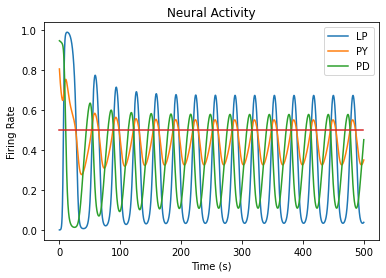

In [4]:
# test adaptive CTRNN class
burst_on_thresh = .5 #the "firing rate threshold" at which the CTRNN neuron is considered to be "bursting"
burst_off_thresh = .4  #the "firing rate" at which the neuron is considered to be effectively silent (just used to determine if oscillation is wide enough)


weights = np.array([[6.60946,1.14559,-6.51152],[10.6385,1.19458,1.34445],[16,1.26722,1.663]])
biases = np.array([-13.1741,-1.54257,-0.114027])
timeconstants = np.array([9.42607,2.41159,7.85833])
duration = 500
dt = .1
C2 = CTRNN(3,0.1,duration,200,.25,weights,biases,timeconstants)
#C2.initializeState(invsigmoid(np.array([5.03977e-14,7.88983e-3,9.95847e-1])))
initial_states = np.array([3.,3.,3.])  #initial states of the neurons
C2.initializeState(initial_states)
C2.resetStepcount()
for i in range(int(duration/dt)):
    C2.ctrnnstep(0)
    
C2.plot()

In [50]:
def genomeconvert(genome):
    '''genome has form [weights,biases,timeconsts] in the actual units of their input (not scaled to 1)'''
    C = CTRNN(3,dt,duration,1,offset,np.reshape(genome[0:9],(3,3)),genome[9:12],genome[12:])
    return C

In [27]:
burst_on_thresh = .5 #the "firing rate threshold" at which the CTRNN neuron is considered to be "bursting"
burst_off_thresh = .45  #the "firing rate" at which the neuron is considered to be effectively silent (just used to determine if oscillation is wide enough)

initial_states = np.array([3.,3.,3.])  #initial states of the neurons
dt=.025
transient = 5000 #in timesteps
HP = 0 #true or false for whether to apply HP

def pyloriclike(genome,HP):
    '''input is an object of the adaptive CTRNN class and output is its fitness as a pyloric-like rhythm. Awards .05 for each oscillating
    neuron, and .05 for each order critereon met. Then, if all order criteria met, adds (1/z-score) for each of 15 criteria in table 1'''
    C = genomeconvert(genome)
    C.initializeState(initial_states)
    C.resetStepcount()
    for i in range(len(C.time)):        #run the CTRNN for the allotted duration
        C.ctrnnstep(HP)
    #check if all three neurons were oscillating (all the way from silent to burst) by the end of the run
    osc = np.zeros(C.Size)
    for i in range(C.Size):
        if max(C.ctrnn_record[i,transient:]) > burst_on_thresh:
            if min(C.ctrnn_record[i,transient:]) < burst_off_thresh:
                osc[i] = 1
    #print(osc)
    fitness = sum(osc)*0.05 #initialize a fitness value based on how many neurons oscillate sufficiently
    if np.all(osc):
        #print("we got oneeeeeee")
        #LP = N1, PY = N2, PD = N3
        #Scan to find second to last full PD cycle
        PDstart3 = 0
        PDstart2 = 0
        PDstart1 = 0
        for i in range(len(C.time))[:transient:-1]:
            if C.ctrnn_record[2,i] > burst_on_thresh:
                if C.ctrnn_record[2,i-1] < burst_on_thresh:
                    PDstart3 = i
                    break
        for i in range(PDstart3)[:transient:-1]:
            if C.ctrnn_record[2,i] > burst_on_thresh:
                if C.ctrnn_record[2,i-1] < burst_on_thresh:
                    PDstart2 = i
                    break
        for i in range(PDstart2)[:transient:-1]:
            if C.ctrnn_record[2,i] > burst_on_thresh:
                if C.ctrnn_record[2,i-1] < burst_on_thresh:
                    PDstart1 = i
                    break
        if (PDstart1 == 0 or PDstart2 == 0):
            print(genome)
            print('could not find 2 full cycles')
            return fitness
        #calculate the start and end times of each neuron's burst in the last full cycle
        PDend = 0 #end of PD burst
        for i in range(PDstart1,PDstart2): 
            if C.ctrnn_record[2,i] > burst_on_thresh:
                if C.ctrnn_record[2,i+1] < burst_on_thresh:
                    PDend = i
                    break
        LPstart = []
        LPend = 0
        for i in range(PDstart1,PDstart2-1):
            if C.ctrnn_record[0,i] < burst_on_thresh:
                if C.ctrnn_record[0,i+1] > burst_on_thresh:
                    LPstart.append(i)
        if len(LPstart)!=1:
            print(genome)
            print('possible double-periodicity')
            return fitness
        LPstart = LPstart[0]
        for i in range(LPstart,len(C.time)-1):
            if C.ctrnn_record[0,i] > burst_on_thresh:
                if C.ctrnn_record[0,i+1] < burst_on_thresh:
                    LPend = i
                    break
        PYstart = []
        PYend = 0
        for i in range(PDstart1,PDstart2-1):
            if C.ctrnn_record[1,i] < burst_on_thresh:
                if C.ctrnn_record[1,i+1] > burst_on_thresh:
                    PYstart.append(i)
        if len(PYstart)!=1:
            print(genome)
            print('possible double-periodicity')
            return fitness
        PYstart = PYstart[0]
        for i in range(PYstart,len(C.time)-1):
            if C.ctrnn_record[1,i] > burst_on_thresh:
                if C.ctrnn_record[1,i+1] < burst_on_thresh:
                    PYend = i
                    break
        #print(PDstart1,PDend,PYstart,PYend,LPstart,LPend)
        #test if in right order
        if LPstart <= PYstart:
            fitness += 0.05
            #print('check1')
        if LPend <= PYend:
            fitness += 0.05
            #print('check2')
        if PDend <= LPstart:
            fitness += 0.05
            #print('check3')
        #if all oscillating in the right order, award fitness for the 15 criteria being close to the mean
        if fitness == 0.3:
            period = PDstart2 - PDstart1
            LPdutycycle = (LPend-LPstart)/period #burstduration/period
            LPdutycyclezscore = abs(LPdutycycle - .264)/.059
            PYdutycycle = (PYend-PYstart)/period #burstduration/period
            PYdutycyclezscore = abs(PYdutycycle - .348)/.054
            PDdutycycle = (PDend-PDstart1)/period #burstduration/period
            PDdutycyclezscore = abs(PDdutycycle - .385)/.040
            LPstartphase = (LPstart-PDstart1)/period #delay/period
            LPstartphasezscore = abs(LPstartphase - .533)/.054
            PYstartphase = (PYstart-PDstart1)/period #delay/period
            PYstartphasezscore = abs(PYstartphase - .758)/.060
            fitness += 1/(np.average([LPdutycyclezscore,PYdutycyclezscore,PDdutycyclezscore,LPstartphasezscore,PYstartphasezscore]))
    return fitness       
#need to detect if more than one or no full burst from neurons 1 and 2 during the course of one cycle of neuron 3

In [7]:
#generate random circuits (standard ranges for parameters with no HP) and test them to see how many are pyloric-like
n = 2000 #number of random CTRNNs to generate
duration = 1000 #in seconds
burst_on_thresh = .5 #the "firing rate threshold" at which the CTRNN neuron is considered to be "bursting"
burst_off_thresh = .4  #the "firing rate" at which the neuron is considered to be effectively silent (just used to determine if oscillation is wide enough)
initial_states = np.array([3.,3.,3.])  #initial states of the neurons
transient = 8000 #in timesteps

success_count = 0
for i in range(n):
    if i%500 == 0:
        print("n=",i)
    weights = np.random.uniform(-16,16,(3,3))
    biases = np.random.uniform(-16,16,3)
    time_consts = np.random.uniform(.5,10,3)
    C = CTRNN(3,0.1,duration,1,.25,weights,biases,time_consts)
    if pyloriclike(C,0):
        success_count += 1
        print("weights", C.Weights, "biases", C.Biases, "time constants", C.invTimeConstants)
        C.plot()

n= 0


TypeError: 'CTRNN' object is not subscriptable

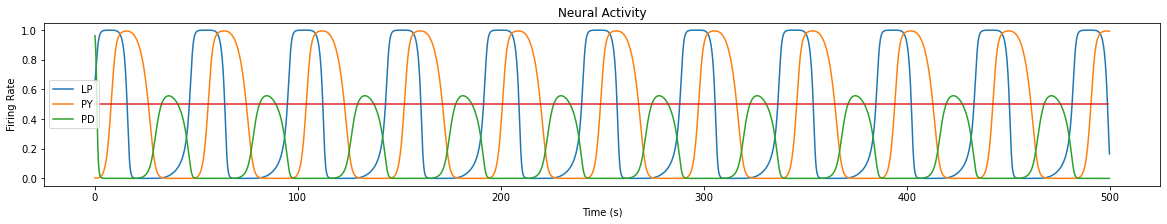

In [33]:
weights = np.array([[13.47792516,  10.59233265, -15.04646692],[-15.97458819,   5.7376846,   -5.37480922],[-2.20731148, -11.07581759,  -3.1880527]])
biases = np.array([-0.39843736, -6.68032731,  2.26812979])
timeconstants = 1/np.array([0.14892103, 0.12300845, 0.25616658])
C1 = CTRNN(3,0.1,duration,200,.25,weights,biases,timeconstants)
for i in range(len(C1.time)):        #run the CTRNN for the allotted duration
        C1.ctrnnstep(HP)
C1.plot()
plt.plot(np.arange(int(len(C1.time)*dt)),np.ones(int(len(C1.time)*dt))*burst_on_thresh)
plt.show()

weights = np.array([])
biases = np.array([])
timeconstants = 1/np.array([])
C2 = CTRNN(3,0.1,duration,200,.25,weights,biases,timeconstants)
for i in range(len(C2.time)):        #run the CTRNN for the allotted duration
        C2.ctrnnstep(HP)
C2.plot()
plt.plot(np.arange(int(len(C2.time)*dt)),np.ones(int(len(C2.time)*dt))*burst_on_thresh)

weights = np.array([])
biases = np.array([])
timeconstants = 1/np.array([])
C3 = CTRNN(3,0.1,duration,200,.25,weights,biases,timeconstants)
for i in range(len(C3.time)):        #run the CTRNN for the allotted duration
        C3.ctrnnstep(HP)
C3.plot()
plt.plot(np.arange(int(len(C3.time)*dt)),np.ones(int(len(C3.time)*dt))*burst_on_thresh)

In [41]:
a = np.array([[1,2,3,4,5,6,7,8,9],[1,2,3,4,5,6,7,8,9]])
np.clip(-np.sum(a[1,0:9])/2,-16,16) #set to clipped center crossing condition


-16.0

Microbial Evolutionary Algorithm

ideas to improve: seed with larger CC population so its less likely that only one order of oscillator will evolve

In [42]:
class Microbial():

    def __init__(self, fitnessFunction, popsize, genesize, recombProb, mutatProb, generations):
        self.fitnessFunction = fitnessFunction
        self.popsize = popsize
        self.genesize = genesize
        self.recombProb = recombProb
        self.mutatProb = mutatProb
        self.generations = generations
        self.tournaments = generations*popsize
        self.pop = np.random.rand(popsize,genesize)                                       #[0,1]
        self.pop = self.pop * np.array([32,32,32,32,32,32,32,32,32,32,32,32,4.5,4.5,4.5]) #scale
        self.pop = self.pop - np.array([16,16,16,16,16,16,16,16,16,16,16,16,-.5,-.5,-.5]) #shift
        self.fitness = np.zeros(popsize)
        self.avgHistory = np.zeros(generations)
        self.bestHistory = np.zeros(generations)
        self.gen = 0
        for indiv in range(len(self.pop)):
            for bias in range(9,12): #three-neuron specific
                self.pop[indiv,bias] = np.clip(-np.sum(self.pop[indiv,0:9])/2,-16,16) #set to clipped center crossing condition


    def showFitness(self):
        plt.plot(self.bestHistory)
        plt.plot(self.avgHistory)
        plt.xlabel("Generations")
        plt.ylabel("Fitness")
        plt.title("Best and average fitness")
        plt.show()

    def fitStats(self):
        bestind = self.pop[np.argmax(self.fitness)]
        bestfit = np.max(self.fitness)
        avgfit = np.mean(self.fitness)
        self.avgHistory[self.gen]=avgfit
        self.bestHistory[self.gen]=bestfit
        return avgfit, bestfit, bestind

    def save(self,filename):
        af,bf,bi = self.fitStats()
        np.savez(filename, avghist=self.avgHistory, besthist=self.bestHistory, bestind=bi)

    def run(self):
        # Calculate all fitness once
        for i in range(self.popsize):
            self.fitness[i] = self.fitnessFunction(self.pop[i],0)
        # Evolutionary loop
        for g in range(self.generations):
            self.gen = g
            # Report statistics every generation
            self.fitStats()
            for i in range(self.popsize):
                # Step 1: Pick 2 individuals
                a = np.random.randint(0,self.popsize-1)
                b = np.random.randint(0,self.popsize-1)
                while (a==b):   # Make sure they are two different individuals
                    b = np.random.randint(0,self.popsize-1)
                # Step 2: Compare their fitness
                if (self.fitness[a] > self.fitness[b]):
                    winner = a
                    loser = b
                else:
                    winner = b
                    loser = a
                # Step 3: Transfect loser with winner --- Could be made more efficient using Numpy
                for l in range(self.genesize):
                    if (np.random.random() < self.recombProb):
                        self.pop[loser][l] = self.pop[winner][l]
                # Step 4: Mutate loser and make sure new organism stays within bounds
                self.pop[loser] += np.random.normal(0.0,self.mutatProb,size=self.genesize)
                self.pop[loser] = np.clip(self.pop[loser],np.array([-16,-16,-16,-16,-16,-16,-16,-16,-16,-16,-16,-16,.5,.5,.5]),np.array([16,16,16,16,16,16,16,16,16,16,16,16,5,5,5]))
                # Save fitness
                self.fitness[loser] = self.fitnessFunction(self.pop[loser],0)
            if self.gen%20 == 0:
                print(self.gen)
        return self.pop

In [ ]:
popsize = 50
genesize = 15
recombProb = .5
mutatProb = .2
generations = 200
M = Microbial(pyloriclike, popsize, genesize, recombProb, mutatProb, generations)
M.run()

0


In [82]:
#M.pop[np.where(max(M.fitness))][0]
M.fitness

array([0.  , 0.  , 0.05, 0.  , 0.  , 0.  , 0.05, 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

In [ ]:
dt = .025
popgenomes = M.pop

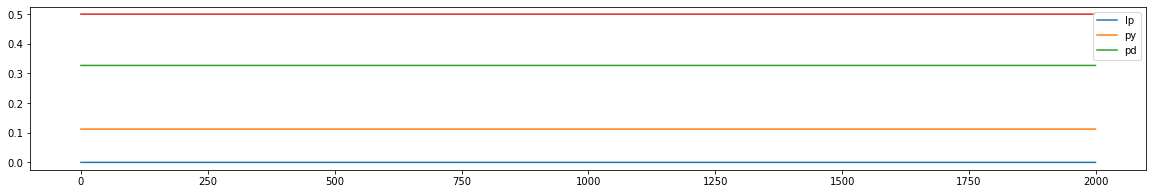

In [85]:
HP = 0 #HP on or off
offset = 0.25 #set target range
#C=genomeconvert([ 14.82024187,  10.61253584, -12.15141158,  -4.61967513,-15.81543225,  15.62745189,  14.71262429,   2.0523492 , 1.86045721, -10.25813196,  -0.29218389,  -2.47607644, 1.13091869,   4.00518322,   3.57617411]) #Correct order but probably not the best z-scores
C=genomeconvert([ 14.82024187,  10.61253584, -12.15141158,  -4.61967513,-15.81543225,  15.62745189,  0,0,0, -10.25813196,  -0.29218389,  -2.47607644, 1.13091869,   4.00518322,   3.57617411]) #Ablate weights to see if any pair is a sufficient oscillator
C.initializeState(initial_states)
C.resetStepcount()
for i in range(len(C.time)):        #run the CTRNN for the allotted duration
    C.ctrnnstep(HP)
#C.plot()
plt.plot(np.arange(2000),C.ctrnn_record[0,-2000:],label='lp')
plt.plot(np.arange(2000),C.ctrnn_record[1,-2000:],label='py')
plt.plot(np.arange(2000),C.ctrnn_record[2,-2000:],label='pd')
plt.plot(np.arange(2000),np.ones(2000)*.5)
#xvals = np.array([9934, 9948, 9958, 9966, 9958, 9974])-(np.ones(6)*(duration/dt)).astype(int)
#print(xvals[1])
#plt.scatter(xvals+200,(np.ones(6)*.5))
plt.legend()
plt.show()

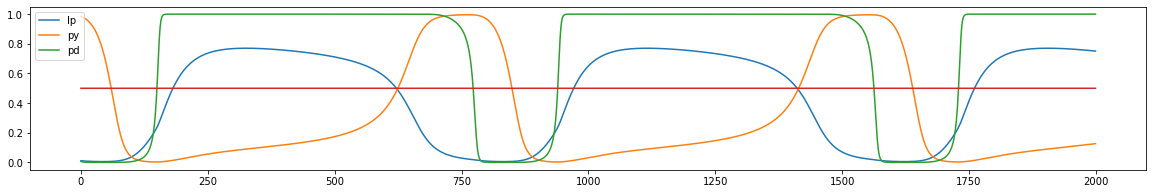

0.25


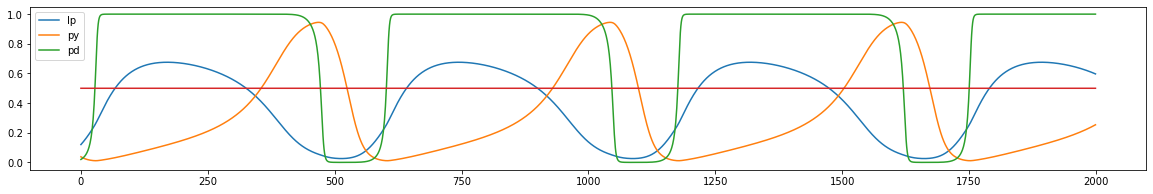

0.25


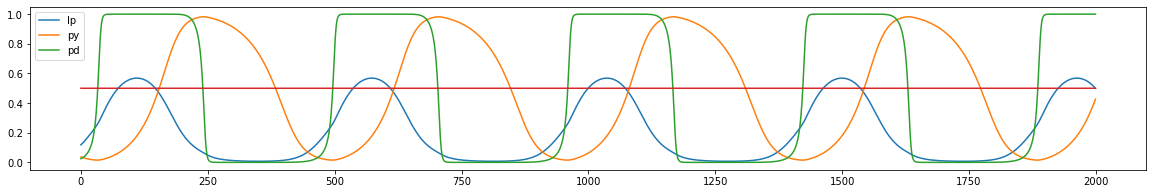

0.25


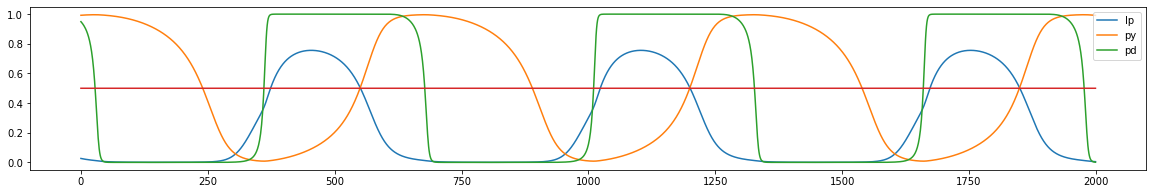

0.25


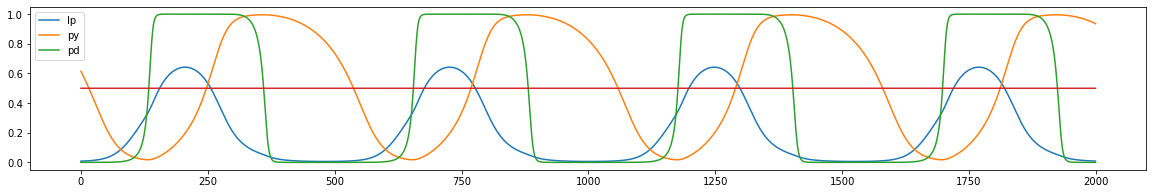

0.25


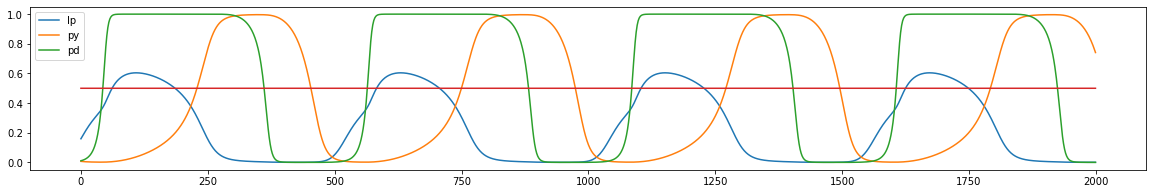

0.25


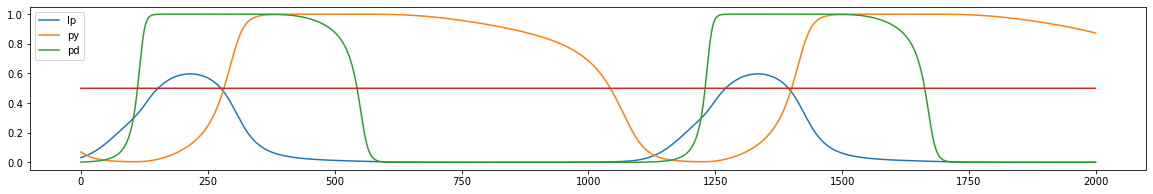

0.25


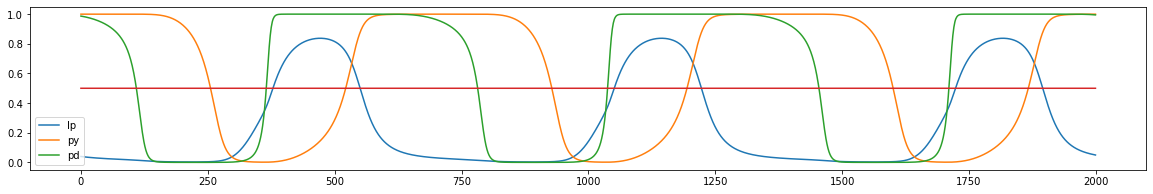

0.25


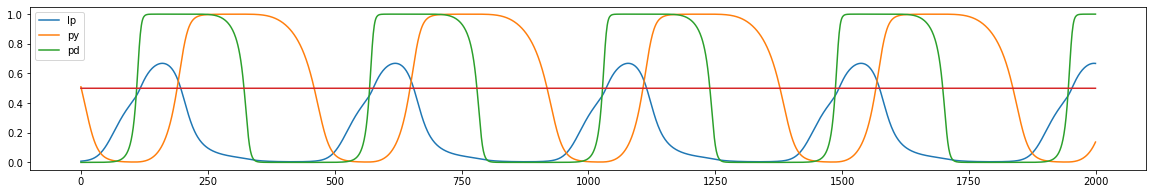

0.25


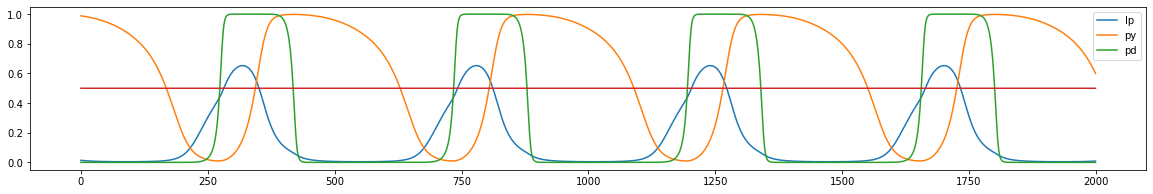

0.25


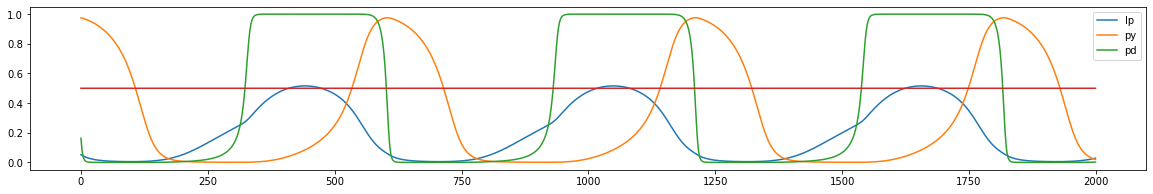

0.25


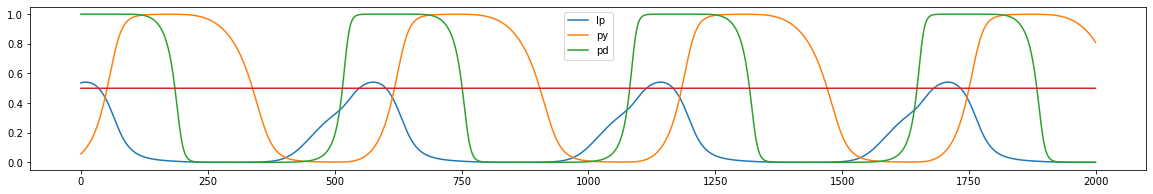

0.25


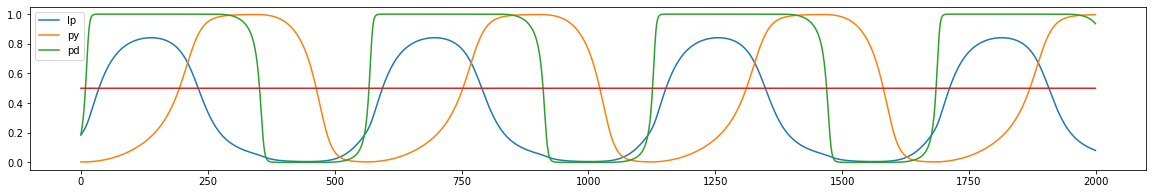

0.25


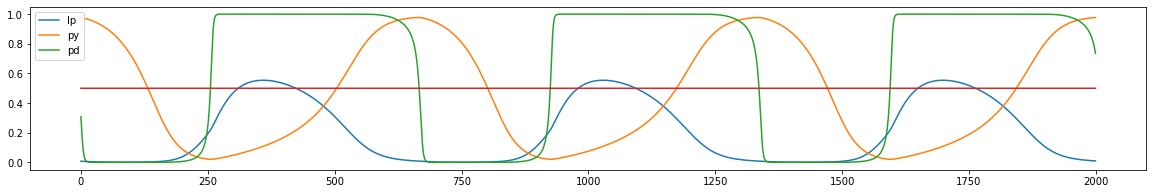

0.25


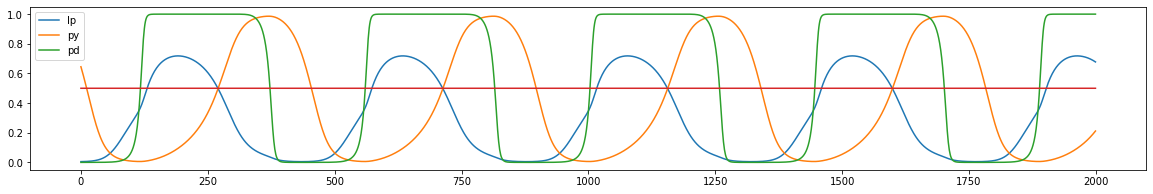

0.25


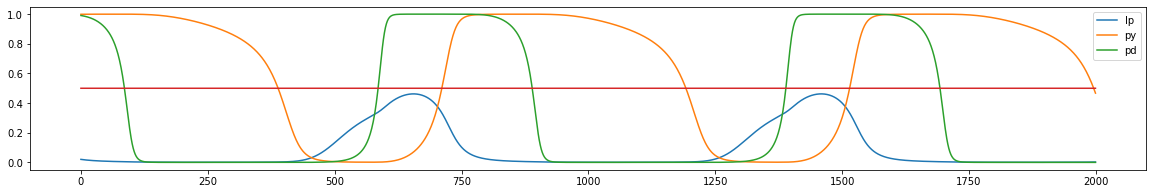

0.1


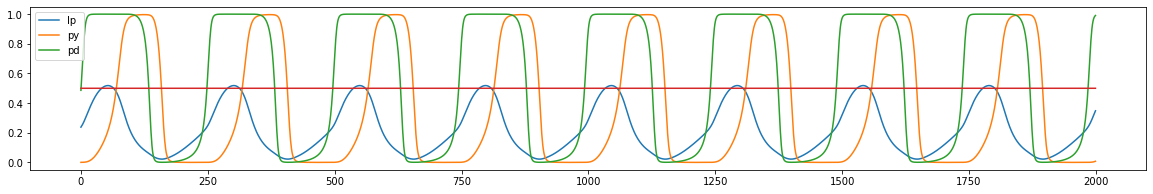

0.25


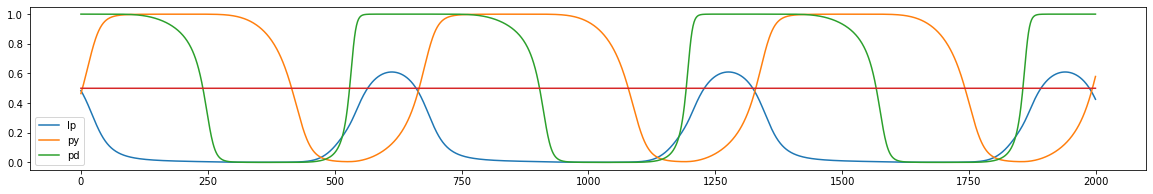

0.25


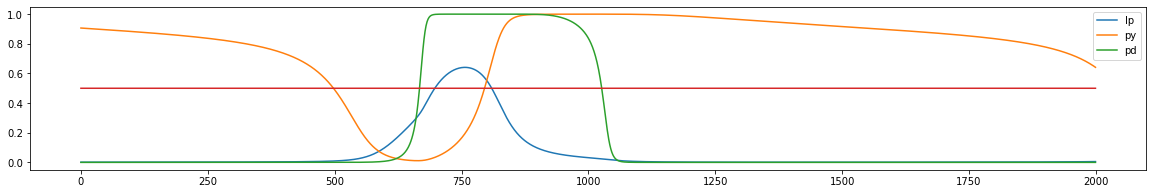

0.25


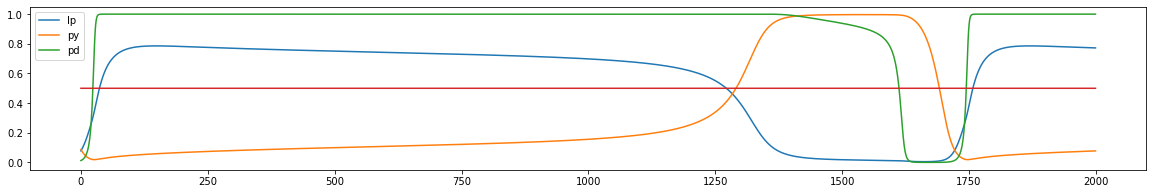

0.25


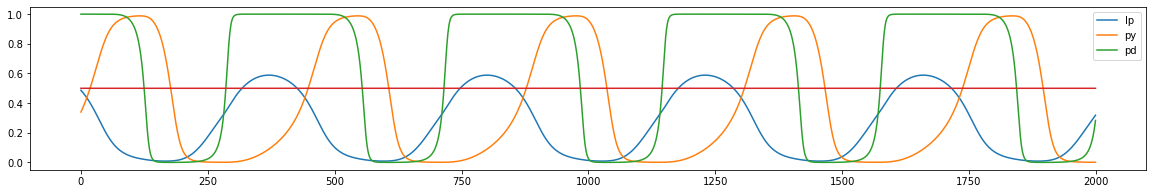

0.25


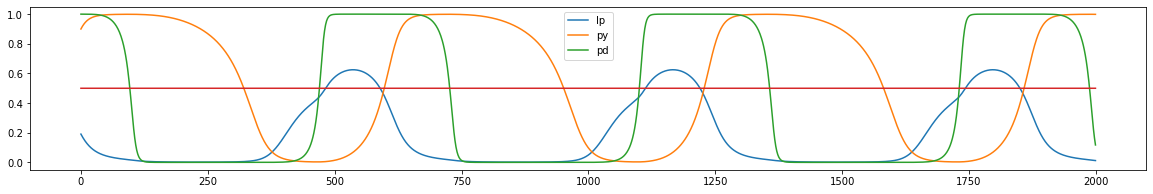

0.25


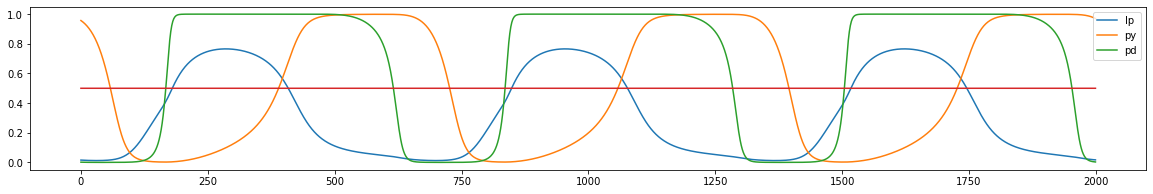

0.25


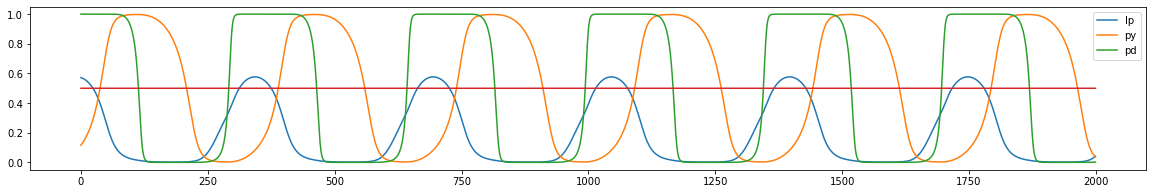

0.25


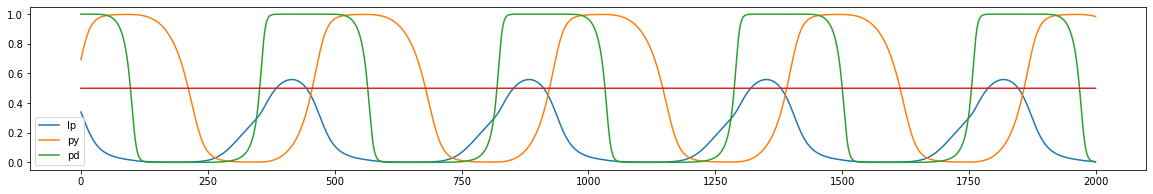

0.25


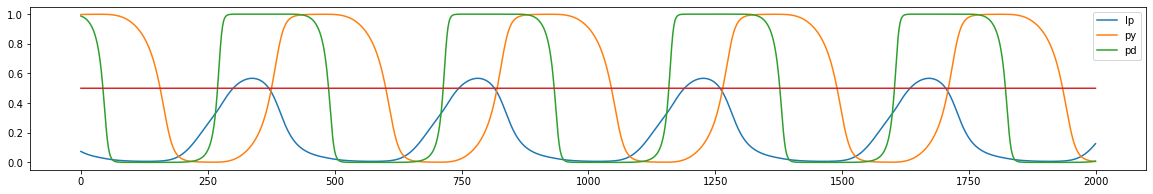

0.25


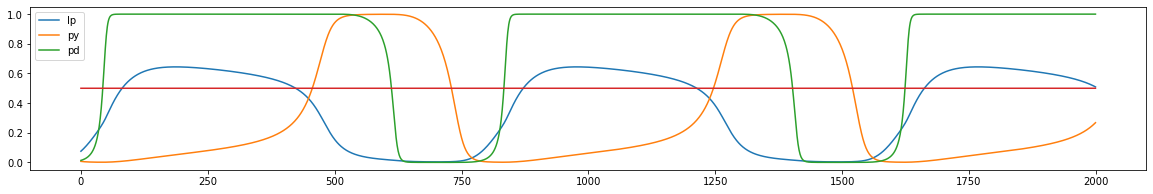

0.25


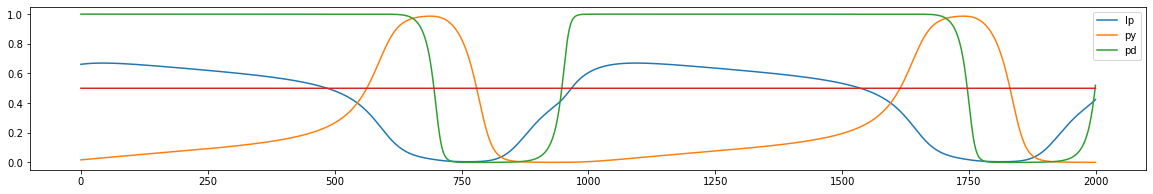

0.25


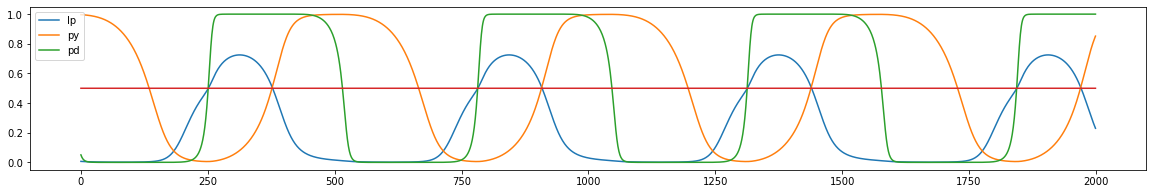

0.25


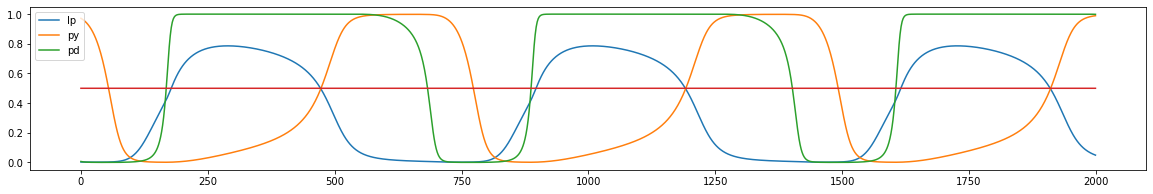

0.25


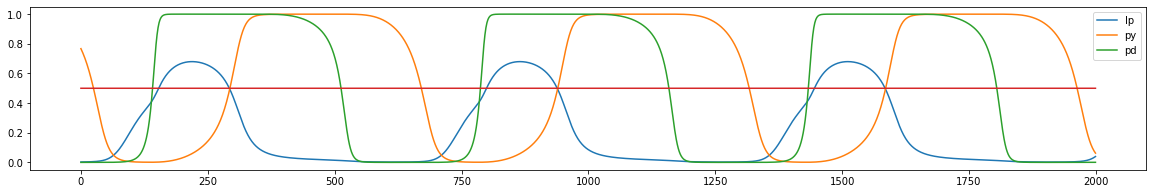

0.25


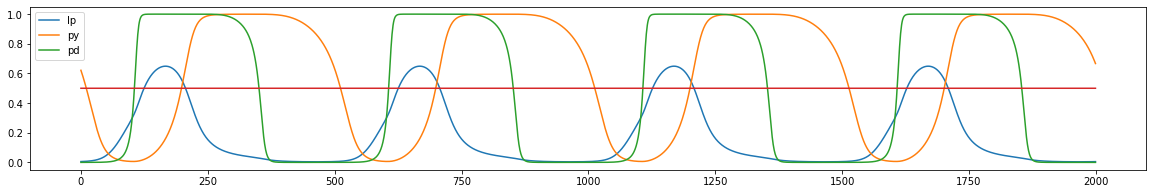

0.25


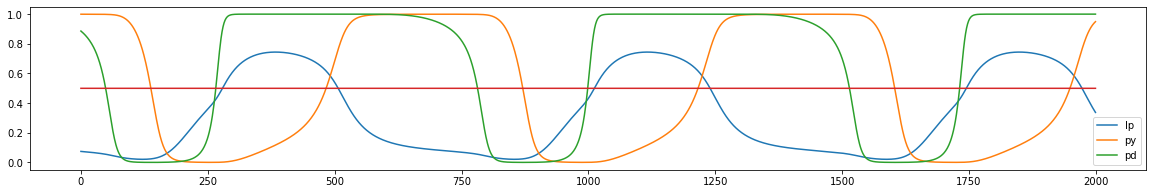

0.25


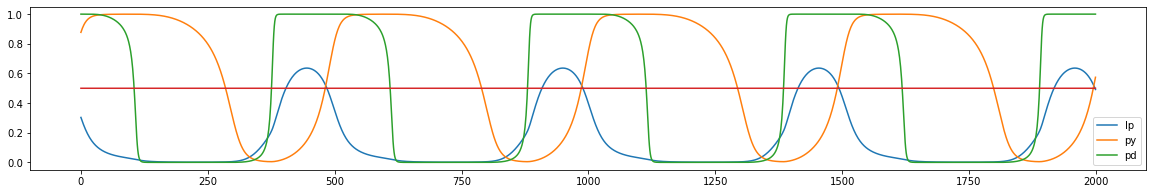

0.25


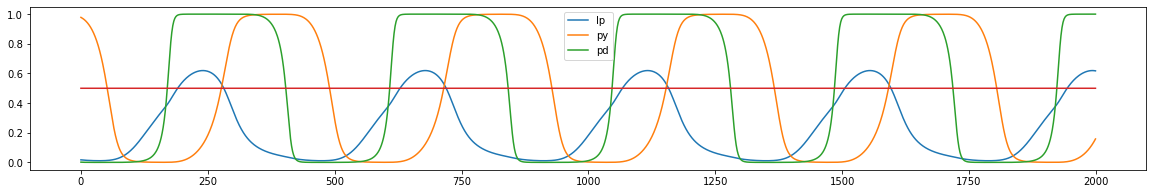

0.25


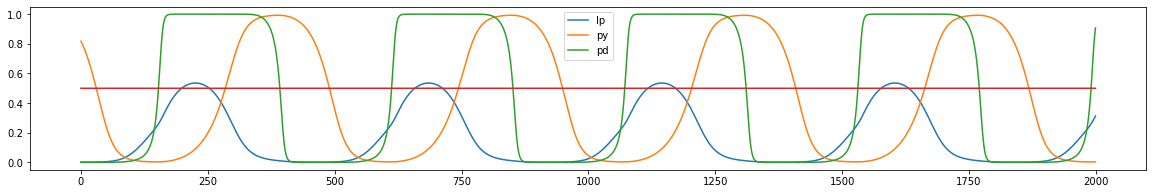

0.25


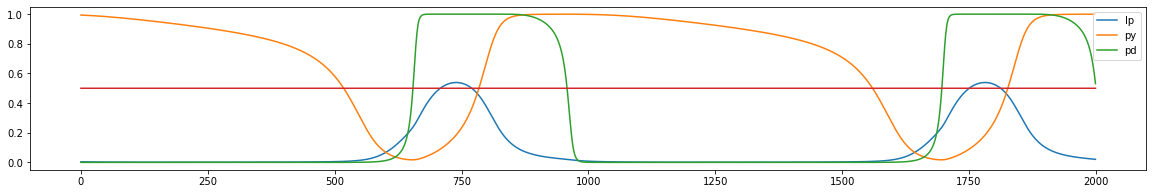

0.25


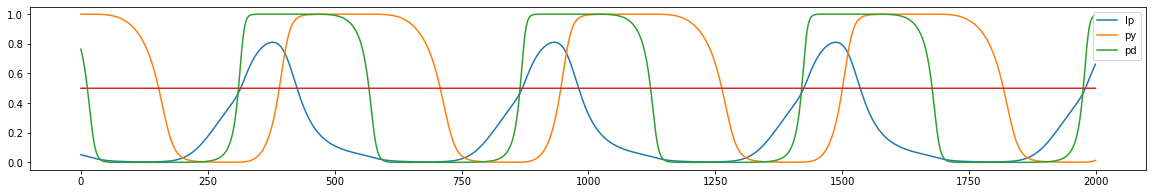

0.25


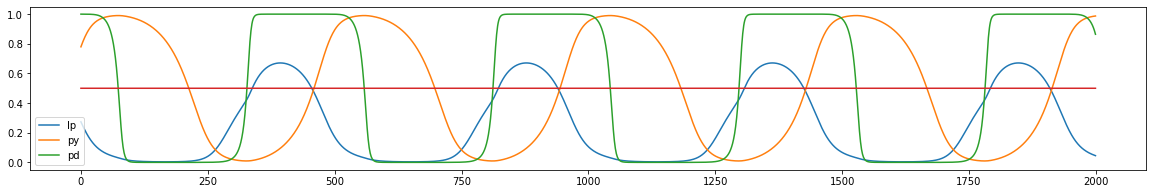

0.25


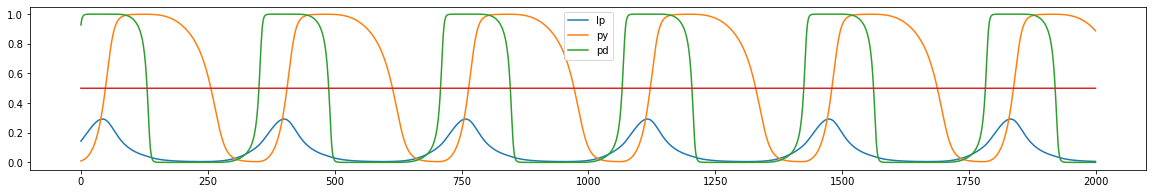

0.1


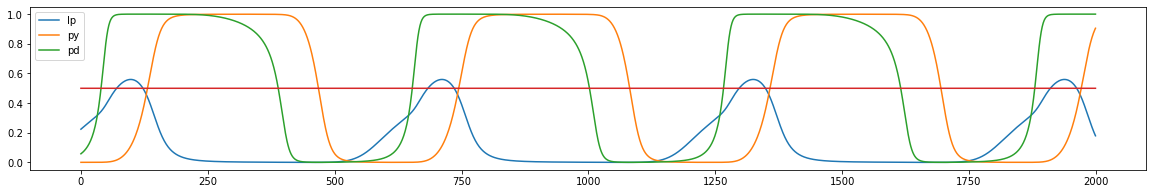

0.25


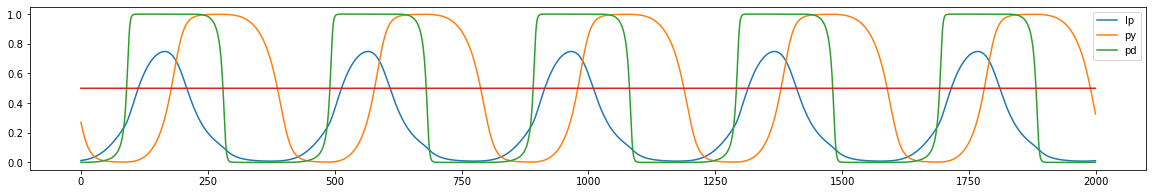

0.25


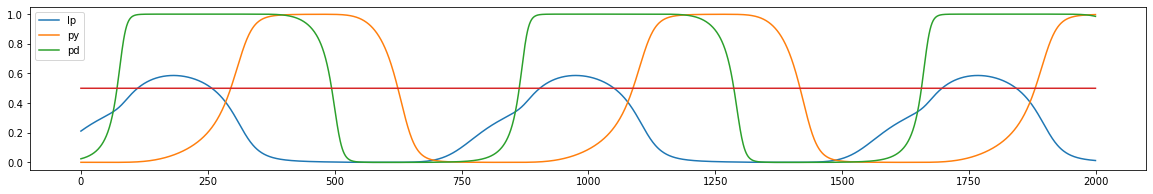

0.25


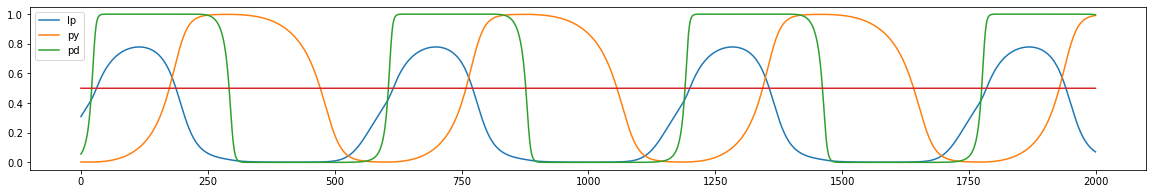

0.25


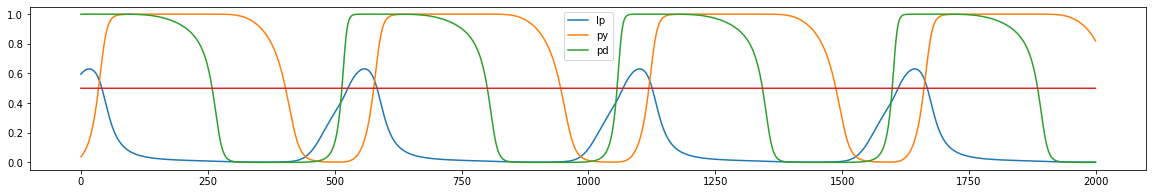

0.25


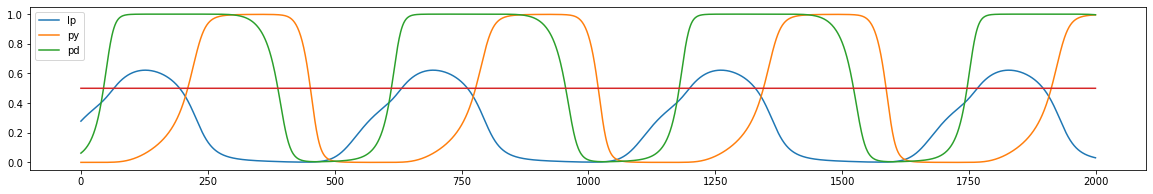

0.25


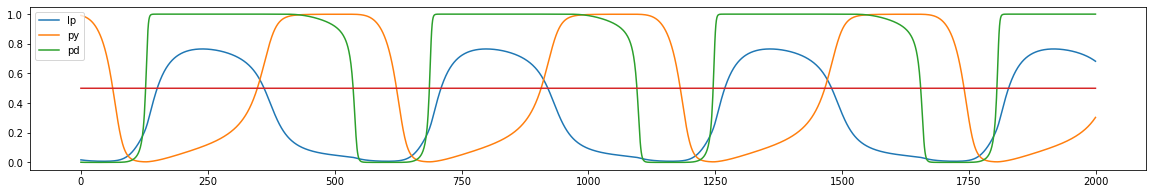

0.25


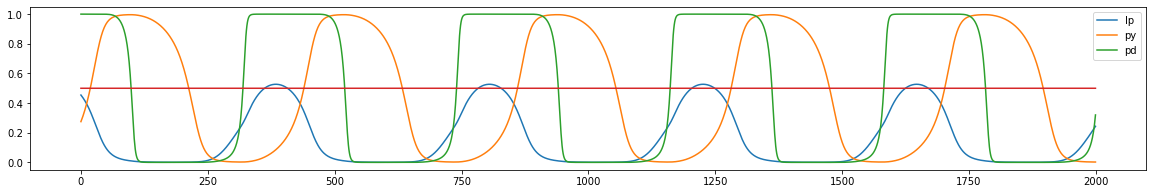

0.25


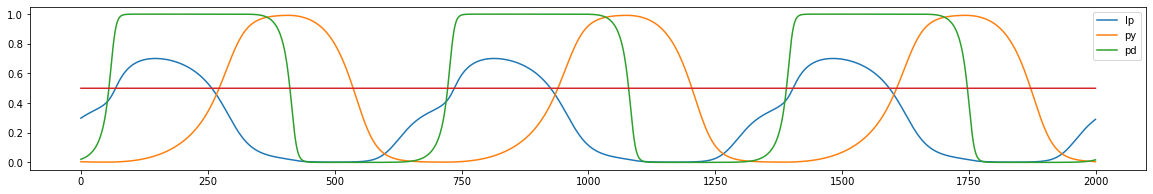

0.25


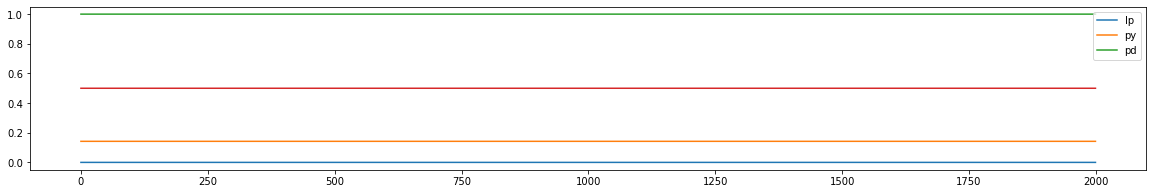

0.0


In [21]:
idx = 0
while idx in range(len(popgenomes)):
    C=genomeconvert(popgenomes[idx])
    C.initializeState(initial_states)
    C.resetStepcount()
    for i in range(len(C.time)):        #run the CTRNN for the allotted duration
        C.ctrnnstep(HP)
    #C.plot()
    plt.plot(np.arange(2000),C.ctrnn_record[0,-2000:],label='lp')
    plt.plot(np.arange(2000),C.ctrnn_record[1,-2000:],label='py')
    plt.plot(np.arange(2000),C.ctrnn_record[2,-2000:],label='pd')
    plt.plot(np.arange(2000),np.ones(2000)*.5)
    #xvals = np.array([9934, 9948, 9958, 9966, 9958, 9974])-(np.ones(6)*(duration/dt)).astype(int)
    #print(xvals[1])
    #plt.scatter(xvals+200,(np.ones(6)*.5))
    plt.legend()
    plt.show()
    print(pyloriclike(popgenomes[idx],0))
    idx += 1

In [14]:
print(pyloriclike(popgenomes[0],0))

we got oneeeeeee
0.25


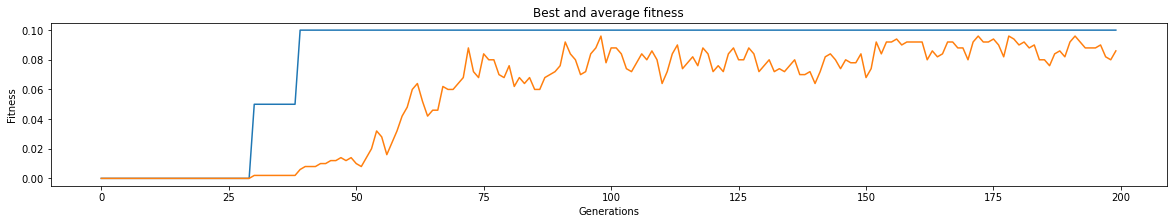

In [151]:
M.showFitness()